# Machine Learning: Loan Default Predictor

## **Introduction:**

In this project I will be using a loan data set to make predictions on whether a loan (with certain characteristics) will default.

I will train the following models:

- Logistic Regression: Baseline  model for performance comparison.
- Random Forest: Ensemble method known for its ability to handle complex data structures.
- Gradient Boosting Machine (GBM) OR XGBoost: Advanced ensemble tknown for their predictive ability.
- Neural Network: An approximation method known for it’s ability to identify non-linear relationships.
- AutoGluon Weighted Ensemble.



## Load Libraries:

In [3]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules
from sklearn.model_selection import train_test_split    #- partition train/test split
from sklearn.ensemble import RandomForestClassifier     #- random forest classifier
from sklearn.ensemble import GradientBoostingClassifier #- GBM classfier
from sklearn.neural_network import MLPClassifier        #- multi-layer perceptron

# -- we need these to make our pipelines
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

# -- we need these to evaluate our models
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# -- need this to render charts in notebook --
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler


## Load Data:

In [4]:
loan = pd.read_csv('https://raw.githubusercontent.com/MikeVej/ML_LoanDefaults/main/Loan%20Data/loan_train.csv')
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501.0,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430.0,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1076863.0,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1069639.0,1304742.0,7000.0,7000.0,7000.0,60 months,15.96%,170.08,C,C5,...,NaN,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1072053.0,1288686.0,3000.0,3000.0,3000.0,36 months,18.64%,109.43,E,E1,...,NaN,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


### Columns in data

In [5]:
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [6]:
loan.loan_status.value_counts(normalize=True)

current    0.849649
default    0.150351
Name: loan_status, dtype: float64

In [7]:
loan_status_types = loan['loan_status'].unique()
print(loan_status_types)

['current' 'default']


In [8]:
loan_status_types = loan['purpose'].unique()
print(loan_status_types)

['credit_card' 'car' 'other' 'debt_consolidation' 'small_business'
 'major_purchase' 'moving' 'home_improvement' 'medical' 'vacation' 'house'
 'wedding' 'renewable_energy' 'educational' nan]


## Exporatory Analysis

### Zips where default is > 30

In [9]:
# Zip codes where default counts is > 30
zip_df = loan.pivot_table(index='zip_code', columns='loan_status', aggfunc='size', fill_value=0)

df_postal_count = loan.groupby(['zip_code'])['loan_status'].count().to_frame()

postal_list = list(df_postal_count[df_postal_count['loan_status']>=30].index)

###  Graph: Top defaults by zip code

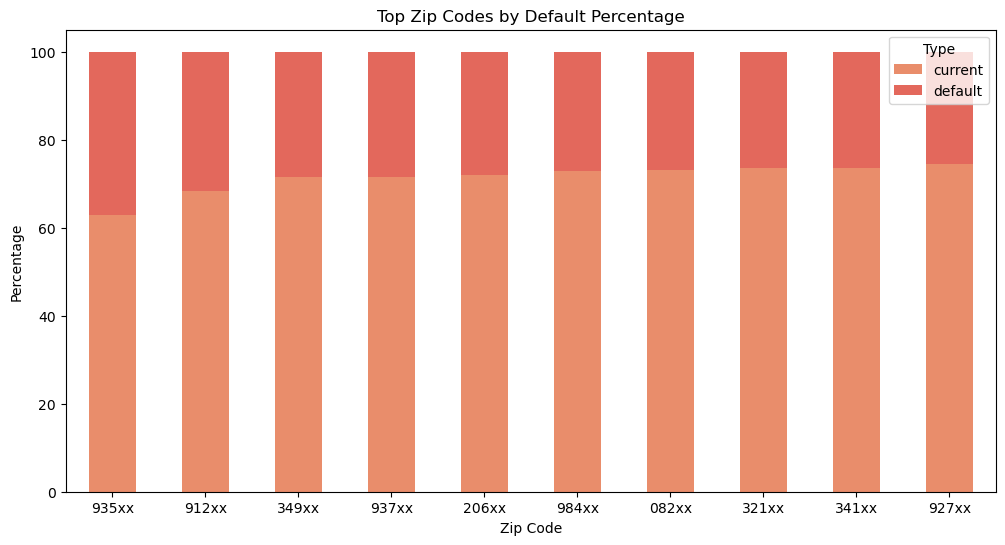

In [10]:
zip_df.reset_index()
# Calculate percentages
pivot_percentage = zip_df[['current', 'default']].div(zip_df[['current', 'default']].sum(axis=1), axis=0) * 100
pivot_percentage = pivot_percentage.sort_values('default',ascending=False)
df_viz = pivot_percentage[pivot_percentage.index.isin(postal_list)]
sns.set_palette("flare")
df_viz.head(10).plot(kind='bar', stacked=True, grid=False, figsize=(12, 6))
plt.title('Top Zip Codes by Default Percentage')
plt.xlabel('Zip Code')
plt.ylabel('Percentage')
plt.legend(title='Type')
plt.xticks(rotation=0)
plt.show()

### Graph: Top Defaults by emplyment length

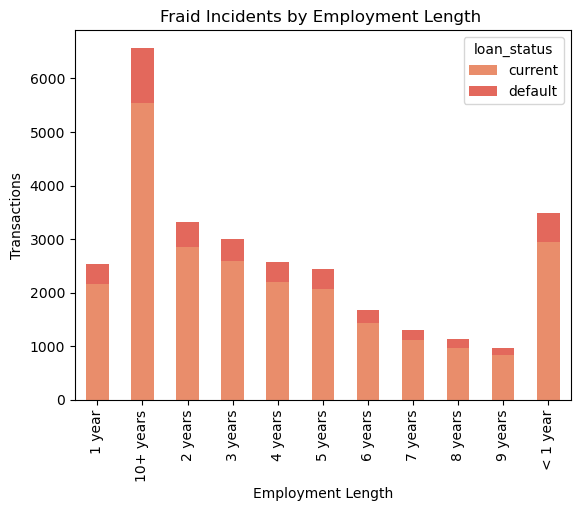

In [11]:
#Plot Fraud Incidents by years working
df_pivot = loan.pivot_table(index='emp_length', columns='loan_status', aggfunc='size', fill_value=0)
df_pivot.plot.bar(stacked=True, grid=False)
plt.xlabel('Employment Length')
plt.ylabel('Transactions')
plt.title('Fraid Incidents by Employment Length ')
plt.show()

### Graph: Numeric Variable Distributions

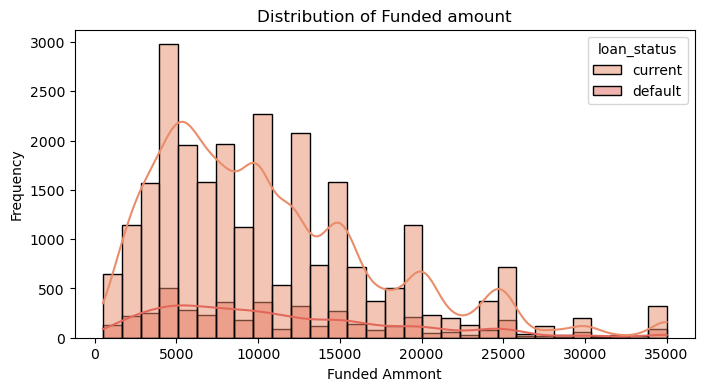

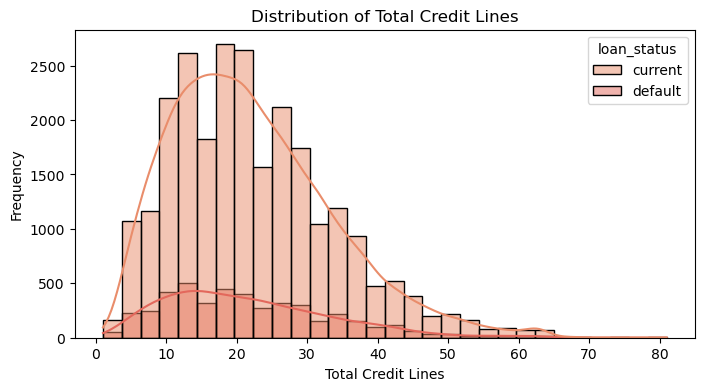

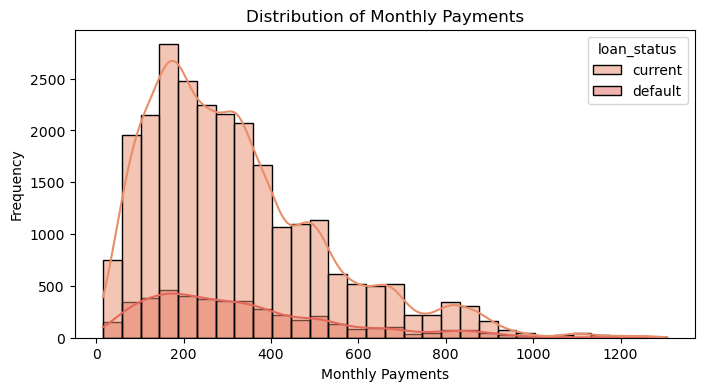

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(data= loan, x='funded_amnt', hue="loan_status", kde=True, bins=30)
plt.title(f'Distribution of Funded amount')
plt.xlabel('Funded Ammont')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data= loan, x='total_acc', hue="loan_status", kde=True, bins=30)
plt.title(f'Distribution of Total Credit Lines')
plt.xlabel('Total Credit Lines')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data= loan, x='installment', hue="loan_status", kde=True, bins=30)
plt.title(f'Distribution of Monthly Payments')
plt.xlabel('Monthly Payments')
plt.ylabel('Frequency')
plt.show()
    

## Data Prep:

### Identify features (Categorical/Numerical):

#### Describe Data:

In [13]:
def df_profile(df, target):

    df = loan.copy()

    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]
    pd.options.display.float_format = '{:.5f}'.format

    categorical_features = [ c for c in df.select_dtypes(include = "object").columns ]

    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt


    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)

    df_stats['feature_type'] = "UNKNOWN"
    df_stats.loc[np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats['dtype'] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[df_stats['feature_name'] == target, 'feature_type'] = "TARGET"

    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats['nunique_pct'] > 0.9, 'feature_warning'] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[df_stats['null_pct'] > 0.2, 'feature_warning'] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats['null_pct'] > 0.5, 'feature_warning'] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[np.logical_and(np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), df_stats['nunique'] <= 20), 'feature_warning'] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return df_stats

dfp = df_profile(loan, 'loan_status')
dfp

,feature_name,dtype,count,nunique,mean,min,max,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,id,float64,29774,29774,663006.18452,54734.00000,1077501.00000,3,29774,0.00010,0.99990,NUMERIC,"EXCLUDE, GT 90% UNIQUE"
1,fico_range_low,float64,29774,43,713.05317,610.00000,825.00000,3,29774,0.00010,0.00144,NUMERIC,NO WARNING
2,fico_range_high,float64,29774,43,717.05317,614.00000,829.00000,3,29774,0.00010,0.00144,NUMERIC,NO WARNING
3,inq_last_6mths,float64,29754,27,1.08409,0.00000,33.00000,23,29754,0.00077,0.00091,NUMERIC,NO WARNING
4,mths_since_last_delinq,float64,10870,90,34.71582,0.00000,120.00000,18907,10870,0.63495,0.00302,NUMERIC,"EXCLUDE, GT 50% MISSING"
5,mths_since_last_record,float64,2569,107,59.22538,0.00000,129.00000,27208,2569,0.91373,0.00359,NUMERIC,"EXCLUDE, GT 50% MISSING"
6,open_acc,float64,29754,44,9.33901,1.00000,47.00000,23,29754,0.00077,0.00148,NUMERIC,NO WARNING
7,pub_rec,float64,29754,6,0.05855,0.00000,5.00000,23,29754,0.00077,0.00020,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
8,revol_bal,float64,29774,18399,14310.00064,0.00000,1207359.00000,3,29774,0.00010,0.61789,NUMERIC,NO WARNING
9,pub_rec_bankruptcies,float64,28811,3,0.04533,0.00000,2.00000,966,28811,0.03244,0.00010,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"


#### Split Features:

##### Numerical Features

In [25]:
numeric_features =  dfp.query('feature_type == "NUMERIC"')['feature_name'].to_list()
print(numeric_features)

['id', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'pub_rec_bankruptcies', 'total_acc', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'out_prncp', 'dti', 'delinq_2yrs', 'tax_liens', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'annual_inc', 'installment']


In [26]:
numeric_features = ['fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 
                    'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'pub_rec_bankruptcies', 
                    'total_acc', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 
                    'policy_code', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'out_prncp', 'dti', 
                    'delinq_2yrs', 'tax_liens', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'annual_inc', 
                    'installment']


##### Categorical Features

In [27]:
categorical_features = dfp.query('feature_type == "CATEGORY"')['feature_name'].to_list()
print(categorical_features)

['application_type', 'term', 'last_credit_pull_d', 'next_pymnt_d', 'int_rate', 'last_pymnt_d', 'grade', 'sub_grade', 'zip_code', 'revol_util', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'url', 'earliest_cr_line', 'desc', 'purpose', 'addr_state', 'title', 'emp_title']


In [ ]:
categorical_features = ['application_type', 'term', 'last_credit_pull_d', 'next_pymnt_d', 'int_rate', 
                        'last_pymnt_d', 'grade', 'sub_grade', 'zip_code', 'revol_util', 'emp_length', 
                        'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'url', 
                        'earliest_cr_line', 'desc', 'purpose', 'addr_state', 'title', 'emp_title']

#### Clean Columns:

#### Application type: Fill nulls with "co-borrowers"

In [14]:
loan['application_type'].fillna('COSIGNED', inplace=True)
loan['application_type'].fillna('COSIGNED', inplace=True)
loan_status_types = loan['application_type'].unique()
print(loan_status_types)

['INDIVIDUAL' 'COSIGNED']


#### Graph: Numerical Correlation Matrix

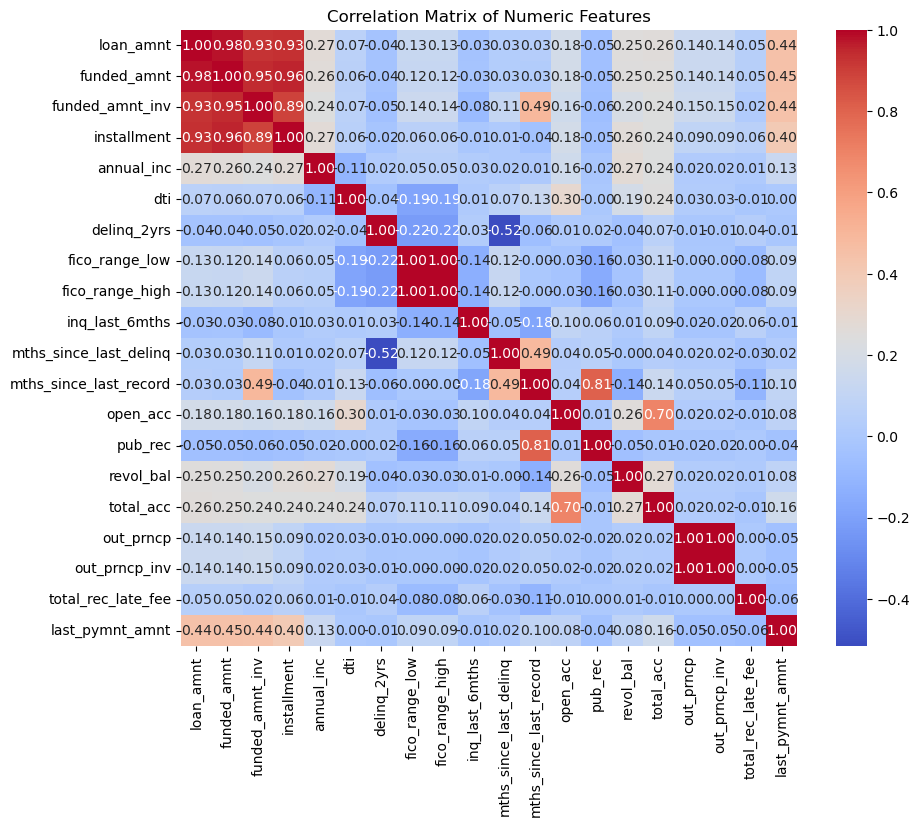

In [17]:
# Compute the correlation matrix
corr = loan[numeric_features].corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

### Loan status to binary [0,1]

In [19]:
target = 'loan_status'
loan[target] = loan[target].map({'current': 0, 'default': 1})
loan[target].value_counts()

0    25300
1     4477
Name: loan_status, dtype: int64

### Train, Test, Split